In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import numpy as np
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [2]:

class PPO_PT(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, act_dim),
        )

    def forward(self, x):
        return self.fc(x)

    def act(self, obs):
        logits = self.forward(obs)
        dist = Categorical(logits=logits)
        action = dist.sample()
        return action.item(), dist.log_prob(action), dist.entropy()

def evaluate_policy(env, policy, episodes=5):
    rewards_obj1, rewards_obj2 = [], []

    for _ in range(episodes):
        obs = env.reset()[0]
        total_r1, total_r2 = 0, 0
        done = False
        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32)
            action, _, _ = policy.act(obs_tensor)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            total_r1 += 1
            
            total_r2 -= int(action != 0)

        rewards_obj1.append(total_r1)
        rewards_obj2.append(total_r2)

    return np.mean(rewards_obj1), np.mean(rewards_obj2)

In [3]:
# Predictor
def predictor_step(theta_prev, theta_curr, h=0.05):
    direction = theta_curr - theta_prev
    norm = np.linalg.norm(direction)
    return theta_curr + h * direction / (norm + 1e-8)

In [4]:
# Corrector
def corrector_step(policy, env, weights, lr=1e-3, epochs=5):
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    gamma = 0.99

    for _ in range(epochs):
        log_probs, rewards1, rewards2 = [], [], []
        obs = env.reset()[0]
        done = False
        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32)
            action, logp, _ = policy.act(obs_tensor)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            log_probs.append(logp)
            rewards1.append(1)  
            rewards2.append(-int(action != 0))  

        # Escalarización
        R = weights[0] * sum(rewards1) + weights[1] * sum(rewards2)
        loss = -torch.stack(log_probs).sum() * R
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return policy

In [ ]:
if __name__ == "__main__":
    env = gym.make("CartPole-v1")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    weights = [[1.0, 0.0], [0.8, 0.2], [0.5, 0.5], [0.2, 0.8]]  
    pareto_policies = []
    reward_vectors = []

    theta_prev = None

    for w in weights:
        policy = PPO_PT(obs_dim, act_dim)
        policy = corrector_step(policy, env, w)

        r1, r2 = evaluate_policy(env, policy)
        reward_vectors.append([r1, r2])
        pareto_policies.append(policy)

        if theta_prev is not None:
            theta_curr = np.concatenate([p.data.cpu().numpy().flatten() for p in policy.parameters()])
            theta_pred = predictor_step(theta_prev, theta_curr)
            print("Prediction:", theta_pred[:5], "...")
        theta_prev = np.concatenate([p.data.cpu().numpy().flatten() for p in policy.parameters()])

    print("\nAproximation of Pareto Front:")
    for r in reward_vectors:
        print(r)


Predicción de siguiente punto en espacio de políticas: [ 0.01077114 -0.37532043  0.2961777   0.3760385   0.19178525] ...
Predicción de siguiente punto en espacio de políticas: [-0.04358376 -0.41466117 -0.18153918 -0.44915238 -0.31863138] ...
Predicción de siguiente punto en espacio de políticas: [ 0.30320185  0.13759929  0.05108722 -0.0083406  -0.3153256 ] ...

Frente aproximado:
[15.6, -5.2]
[25.8, -13.8]
[19.0, -8.0]
[14.2, -6.6]


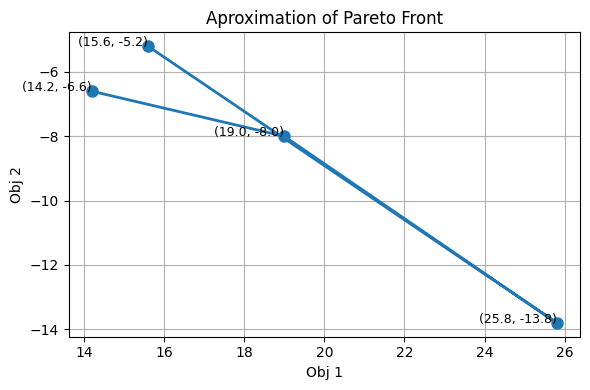

In [ ]:
import matplotlib.pyplot as plt
points = [
(15.6, -5.2),
(25.8, -13.8),
(19.0, -8.0),
(14.2, -6.6)
]
xs, ys = zip(*points)

plt.figure(figsize=(6, 4))
plt.plot(xs, ys, '-o', linewidth=2, markersize=8)
for x, y in points:
    plt.text(x, y, f'({x}, {y})', fontsize=9, ha='right')
plt.title('Aproximation of Pareto Front')
plt.xlabel('Obj 1')
plt.ylabel('Obj 2')
plt.grid(True)
plt.tight_layout()
plt.show()
